In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb
import tensorflow as tf

In [3]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost28_1827.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [ ]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(10)id

In [ ]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [ ]:
pred['pred'] = (pred.RandomForest * 0.04 + pred.XGBoost * 0.03 + pred.NN * 0.03
                + pred.LightGBM * 0.35 + pred.CatBoost * 0.55)
pred.head()

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred['id'],
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

# LogisticRegression

In [5]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [6]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']

In [7]:
rf_model = pickle.load(open('models/RF_22_2248.pkl', 'rb'))
xgb_model = pickle.load(open('models/XG_28_1835.pkl', 'rb'))
lgb_model = pickle.load(open('models/LGBM_op24_0418.pkl', 'rb'))

In [8]:
f_rf = rf_model.predict_proba(x)
first_rf = pd.DataFrame(f_rf)

f_xgb = xgb_model.predict_proba(x)
first_xgb = pd.DataFrame(f_xgb)

f_lgb = lgb_model.predict(x)
first_lgb = pd.DataFrame(f_lgb)

first_pred = np.column_stack((first_rf[1],first_xgb[1], first_lgb[0]))
train_pred = pd.DataFrame(first_pred, columns=('RF', 'XGB', 'LGB'))

train_pred = pd.concat([ID, train_pred, y], axis=1)
train_pred['id'] = [int(i) for i in train_pred['id']]
train_pred.head(-10)

,id,RF,XGB,LGB,y
0,0,0.019764,0.003748,0.041840,0
1,1,0.178051,0.466265,0.178831,1
2,2,0.010521,0.007407,0.036251,0
3,3,0.014289,0.008354,0.040736,0
4,4,0.186455,0.075168,0.118117,0
...,...,...,...,...,...
27085,27085,0.025268,0.010796,0.046788,0
27086,27086,0.023498,0.002702,0.041830,0
27087,27087,0.044049,0.023269,0.051748,0
27088,27088,0.141111,0.163757,0.114841,0


In [9]:
del train_df, test_df, ID, x, y

In [10]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [11]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])

In [12]:
cb_model = pickle.load(open('models/CatBoost_24_0835.pkl', 'rb'))

In [13]:
f_cb = cb_model.predict_proba(x)
first_cb = pd.DataFrame(f_cb)

tmp_train_pred = pd.concat([ID, first_cb[1]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,1
0,0,0.005982
1,1,0.174154
2,2,0.006766
3,3,0.004269
4,4,0.148330
...,...,...
27085,27085,0.011141
27086,27086,0.003571
27087,27087,0.017806
27088,27088,0.182574


In [14]:
tr_pred = pd.merge(train_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={1: 'CB'})

In [16]:
del train_df, test_df, x, ID, tmp_train_pred
gc.collect()

333

In [17]:
train_df = pd.read_csv('dataset/train_nn17_1435.csv')
test_df = pd.read_csv('dataset/test_nn17_1435.csv')

In [18]:
ID = train_df['id']
x = train_df.drop(columns=['id', 'y'])

In [19]:
nn_model = tf.keras.models.load_model('models/nn_model_0.8250201.h5', compile=False)

In [20]:
nn_pred = nn_model.predict(x)
first_nn = pd.DataFrame(nn_pred)

tmp_train_pred = pd.concat([ID, first_nn[0]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,0
0,0,0.003727
1,1,0.105578
2,2,0.004983
3,3,0.010434
4,4,0.110732
...,...,...
27085,27085,0.025660
27086,27086,0.009491
27087,27087,0.025590
27088,27088,0.151165


In [21]:
tr_pred = pd.merge(tr_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={0: 'NN'})

In [22]:
col = ['id', 'RF', 'XGB', 'LGB', 'CB', 'NN', 'y']
tr_pred = tr_pred.reindex(col, axis=1)

del col
tr_pred.head(-10)

,id,RF,XGB,LGB,CB,NN,y
0,0,0.019764,0.003748,0.041840,0.005982,0.003727,0
1,1,0.178051,0.466265,0.178831,0.174154,0.105578,1
2,2,0.010521,0.007407,0.036251,0.006766,0.004983,0
3,3,0.014289,0.008354,0.040736,0.004269,0.010434,0
4,4,0.186455,0.075168,0.118117,0.148330,0.110732,0
...,...,...,...,...,...,...,...
27085,27085,0.025268,0.010796,0.046788,0.011141,0.025660,0
27086,27086,0.023498,0.002702,0.041830,0.003571,0.009491,0
27087,27087,0.044049,0.023269,0.051748,0.017806,0.025590,0
27088,27088,0.141111,0.163757,0.114841,0.182574,0.151165,0


In [23]:
del train_df, test_df, ID, x, tmp_train_pred
gc.collect()

790

In [24]:
x = tr_pred.iloc[:, 1:6]
y = tr_pred['y']
ID = tr_pred['id']

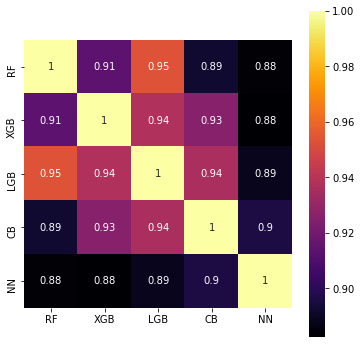

In [25]:
corr = x.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [26]:
def objective_lreg(trial):
    
    param_lreg = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+5)
    }
    
    lreg = LogisticRegression(**param_lreg, max_iter=1000, random_state=18)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(lreg, x, y, n_jobs=-1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [27]:
%%time

study_lreg = optuna.create_study(direction='maximize')
study_lreg.optimize(objective_lreg, n_trials=300, n_jobs=-1)

lreg_best_params = study_lreg.best_params

[I 2020-08-28 18:36:53,920] Finished trial#2 resulted in value: 0.9073696132534401. Current best value is 0.9073696132534401 with parameters: {'C': 6.305720755447713e-06}.
[I 2020-08-28 18:36:53,994] Finished trial#1 resulted in value: 0.9078002003490733. Current best value is 0.9078002003490733 with parameters: {'C': 0.0023278187163140616}.
[I 2020-08-28 18:36:54,239] Finished trial#4 resulted in value: 0.9089049622687269. Current best value is 0.9089049622687269 with parameters: {'C': 0.007307383160702658}.
[I 2020-08-28 18:36:54,240] Finished trial#5 resulted in value: 0.9073704662648969. Current best value is 0.9089049622687269 with parameters: {'C': 0.007307383160702658}.
[I 2020-08-28 18:36:55,060] Finished trial#0 resulted in value: 0.9176030383742649. Current best value is 0.9176030383742649 with parameters: {'C': 3.3263652681041225}.
[I 2020-08-28 18:36:55,131] Finished trial#3 resulted in value: 0.9155938136019932. Current best value is 0.9176030383742649 with parameters: {'C

CPU times: user 4min 44s, sys: 4min 40s, total: 9min 25s
Wall time: 1min 49s


In [28]:
print(study_lreg.best_params)
print('auc:', study_lreg.best_value)

{'C': 0.6365645577132467}
auc: 0.9191532563749643


In [29]:
lreg_best_params = {
        'C': 0.6365645577132467
}

In [30]:
lreg_model = LogisticRegression(**lreg_best_params, max_iter=1000, random_state=18)
lreg_model.fit(x, y)

LogisticRegression(C=0.6365645577132467, max_iter=1000, random_state=18)

In [31]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [32]:
train_pred_df = pd.merge(tr_pred, lreg_pred, on='id')
train_pred_df.head(-10)

,id,RF,XGB,LGB,CB,NN,y,lreg
0,0,0.019764,0.003748,0.041840,0.005982,0.003727,0,0.019996
1,1,0.178051,0.466265,0.178831,0.174154,0.105578,1,0.678656
2,2,0.010521,0.007407,0.036251,0.006766,0.004983,0,0.019597
3,3,0.014289,0.008354,0.040736,0.004269,0.010434,0,0.019518
4,4,0.186455,0.075168,0.118117,0.148330,0.110732,0,0.069475
...,...,...,...,...,...,...,...,...
27085,27085,0.025268,0.010796,0.046788,0.011141,0.025660,0,0.019868
27086,27086,0.023498,0.002702,0.041830,0.003571,0.009491,0,0.019100
27087,27087,0.044049,0.023269,0.051748,0.017806,0.025590,0,0.023591
27088,27088,0.141111,0.163757,0.114841,0.182574,0.151165,0,0.111626


# PREDICT

In [33]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost28_1827.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [34]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(-10)

,id,RandomForest,XGBoost,LightGBM,CatBoost,NN
0,0,0.653176,0.728266,0.359419,0.874176,0.835058
1,1,0.074268,0.112043,0.092231,0.055457,0.099198
2,2,0.039741,0.020388,0.050437,0.024032,0.048758
3,3,0.002598,0.002376,0.035582,0.003217,0.007241
4,4,0.092913,0.035205,0.071720,0.042077,0.070299
...,...,...,...,...,...,...
18035,18035,0.076255,0.039344,0.078328,0.037572,0.022707
18036,18036,0.054682,0.107310,0.077653,0.066366,0.059807
18037,18037,0.001582,0.002429,0.034496,0.002404,0.001839
18038,18038,0.030693,0.010760,0.053604,0.030467,0.009364


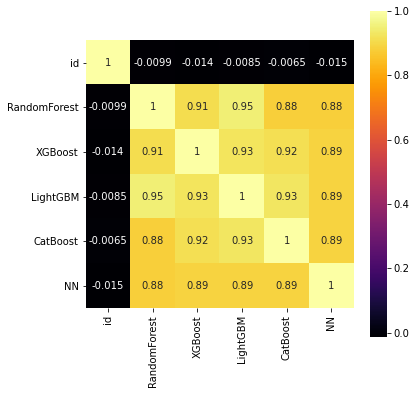

In [35]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [36]:
del x, y, lreg_p, lreg_pred, p_lreg
gc.collect()

174

In [37]:
x = pred.iloc[:, 1:]
ID = pred['id']

In [38]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [39]:
pred_df = pd.merge(pred, lreg_pred, on='id')
pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,CatBoost,NN,lreg
0,0,0.653176,0.728266,0.359419,0.874176,0.835058,0.978353
1,1,0.074268,0.112043,0.092231,0.055457,0.099198,0.046738
2,2,0.039741,0.020388,0.050437,0.024032,0.048758,0.020802
3,3,0.002598,0.002376,0.035582,0.003217,0.007241,0.018123
4,4,0.092913,0.035205,0.071720,0.042077,0.070299,0.027060
...,...,...,...,...,...,...,...
18035,18035,0.076255,0.039344,0.078328,0.037572,0.022707,0.035722
18036,18036,0.054682,0.107310,0.077653,0.066366,0.059807,0.052631
18037,18037,0.001582,0.002429,0.034496,0.002404,0.001839,0.018447
18038,18038,0.030693,0.010760,0.053604,0.030467,0.009364,0.024934


In [49]:
pred_df['pred'] = (pred_df.RandomForest * 0.01 + pred_df.XGBoost * 0.04 + pred_df.NN * 0.01
                + pred_df.LightGBM * 0.3 + pred_df.CatBoost * 0.6 + pred_df.lreg * 0.04)
pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,CatBoost,NN,lreg,pred
0,0,0.653176,0.728266,0.359419,0.874176,0.835058,0.978353,0.715478
1,1,0.074268,0.112043,0.092231,0.055457,0.099198,0.046738,0.069030
2,2,0.039741,0.020388,0.050437,0.024032,0.048758,0.020802,0.032083
3,3,0.002598,0.002376,0.035582,0.003217,0.007241,0.018123,0.013523
4,4,0.092913,0.035205,0.071720,0.042077,0.070299,0.027060,0.050885
...,...,...,...,...,...,...,...,...
18035,18035,0.076255,0.039344,0.078328,0.037572,0.022707,0.035722,0.050034
18036,18036,0.054682,0.107310,0.077653,0.066366,0.059807,0.052631,0.070658
18037,18037,0.001582,0.002429,0.034496,0.002404,0.001839,0.018447,0.012660
18038,18038,0.030693,0.010760,0.053604,0.030467,0.009364,0.024934,0.036190


In [50]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [42]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['lreg']
})

file_name = 'submit/submit_lreg_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)